In [1]:
from TMclass import *
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xml.etree import ElementTree

from datetime import datetime as DT
from datetime import timedelta as TD

def flush_many(max_vol, vol_dataset, phi_mode, start, nbits, ndata, level, partition):
    global PHI
    
    def _new_start(start,end):
        start += TD(days=1)
        start = start.replace(hour=3,minute=0,second=0)
        if end > start:
            start = end + TD(hours=1)
        return start
    

    vol0 = max_vol[0]
    vol1 = max_vol[1]
    n0 = int(vol0 // vol_dataset * 0.99)
    n1 = int(vol1 // vol_dataset * 0.99)

    if ndata == -1:
        ndata = phi_mode.raw.n_datasets
    
    print(f'Days needed: {(ndata-n0)//n1+2}')
    kw = phi_mode.compressing(start, nbits = nbits, ndata = n0,level=level); PHI.saving(partition,**kw)
    # start += TD(days=1)
    start = _new_start(start,kw['end'])

    for i in range((ndata-n0)//n1+1):
        kw = phi_mode.compressing(start, nbits = nbits, ndata = n1,level=level); PHI.saving(partition,**kw)
        start = _new_start(start,kw['end'])

    return (phi_mode, kw)

PHI = PHI_MEMORY(DT.fromisoformat('2022-01-19T23:00:00'))

TM = {'date':[], 'tm_rate':[], 'duration':[]}
TMnew = {'date':[], 'tm_rate':[], 'duration':[]}

with open('../telem.xml') as f:
	tree = ElementTree.parse(f)

for node in tree.iter('PASS'):
    d = DT.fromisoformat(node.attrib.get('comment')[:-1]).date()
    if d >= datetime.date(2022,1,1) and d <= datetime.date(2023,1,1):
        TM['date'] += [DT.fromisoformat(node.attrib.get('comment')[:-1])]
        TM['tm_rate'] += [float(node.attrib.get('tm_rate'))]
        TM['duration'] += [int(node.attrib.get('duration'))]

with open('../EFECS_M06_V00.xml') as f:
	tree = ElementTree.parse(f)

for node in tree.iter('PASS'):
    d = DT.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S").date()
    if d >= datetime.date(2022,1,1) and d <= datetime.date(2023,1,1):
        TMnew['date'] += [DT.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S")]
        TMnew['tm_rate'] += [float(node.attrib.get('tm_rate'))]
        TMnew['duration'] += [int(node.attrib.get('duration'))]

TM['date'] = np.asarray(TM['date'])
TM['tm_rate'] = np.asarray(TM['tm_rate'])
TM['duration'] = np.asarray(TM['duration'])

TMnew['date'] = np.asarray(TMnew['date'])
TMnew['tm_rate'] = np.asarray(TMnew['tm_rate'])
TMnew['duration'] = np.asarray(TMnew['duration'])

f = open('phi.itl','r')
lines = f.readlines()

FL = {'date':[], 'flush':[]}

for x in lines:
    temp = x.split(' ')
    if 'PHI_SCI_Flush_VOL' in temp[-1]:
        FL['date'] += [DT.fromisoformat(temp[0][:-1])]
        FL['flush'] += [float(temp[-1][19:-2])]
        # print(temp[0][:-1],temp[-1][19:-2])

FL['date'] = np.asarray(FL['date'])
FL['flush'] = np.asarray(FL['flush'])

f = open('phi.itl','r')
lines = f.readlines()

# SV = {'date':[], 'rate':[]}

# for x in lines:
#     temp = x.split(' ')
#     if 'PHI_SCI_Rate' in temp[-1]:
#         SV['date'] += [DT.fromisoformat(temp[0][:-1])]
#         SV['rate'] += [float(temp[-1][14:-2])]
#         # print(temp[0][:-1],temp[-1][19:-2])

# SV['date'] = np.asarray(SV['date'])
# SV['rate'] = np.asarray(SV['rate'])

f = open('phi_new.itl','r')
lines = f.readlines()

FLnew = {'date':[], 'flush':[]}

for x in lines:
    temp = x.split(' ')
    if 'PHI_SCI_Flush_VOL' in temp[-1]:
        FLnew['date'] += [DT.fromisoformat(temp[0][:-1])]
        FLnew['flush'] += [float(temp[-1][19:-2])]
        # print(temp[0][:-1],temp[-1][19:-2])

FLnew['date'] = np.asarray(FLnew['date'])
FLnew['flush'] = np.asarray(FLnew['flush'])



In [2]:
def synoptic(mode,t0,t1,cadence,shape,nout,nbits,i,format = False):
    # t0 = DT.fromisoformat('2022-04-15T00:00:00')
    # t1 = DT.fromisoformat('2022-05-01T00:00:00')

    # cad = 6*60
    global PHI
    N = int((t1 - t0).total_seconds() / (60*cadence))

    ti = t0
    deltat = (t1 - t0)/N
    min1 = TD(minutes=1)
    form = False
    for n in range(N):
        kw = mode.observation(ti,ti+min1,cadence=1,shape=shape); PHI.saving(i,**kw)
        if shape[1] != 2048:
            kw = mode.cropping(kw['end'] + TD(minutes=5),ndata=-1,crop=[shape[1],shape[1]],level='raw'); PHI.saving(i,**kw)
            kw = mode.processing(kw['end'] + TD(minutes=5),ndata=-1,partialStore=0x00,level='raw.crop',nout=nout); PHI.saving(i,**kw)
            kw = mode.compressing(kw['end'] + TD(minutes=5), nbits = nbits, ndata = -1,level='proc.crop'); PHI.saving(i,**kw)
        else:
            kw = mode.processing(kw['end'] + TD(minutes=5),ndata=-1,partialStore=0x00,level='raw',nout=nout); PHI.saving(i,**kw)
            kw = mode.compressing(kw['end'] + TD(minutes=5), nbits = nbits, ndata = -1,level='proc'); PHI.saving(i,**kw)
        ti = ti + deltat
        if format:
            if PHI.part1.occu > 220e3 or PHI.part2.occu > 220e3:
                PHI.format_partition(i,kw['end'])
                i = i%2 + 1

def synoptic_raw(mode,t0,t1,cadence,shape,nbits,i,format = False):
    # t0 = DT.fromisoformat('2022-04-15T00:00:00')
    # t1 = DT.fromisoformat('2022-05-01T00:00:00')

    # cad = 6*60
    global PHI
    N = int((t1 - t0).total_seconds() / (60*cadence))

    ti = t0
    deltat = (t1 - t0)/N
    min1 = TD(minutes=1)
    form = False
    for n in range(N):
        kw = mode.observation(ti,ti+min1,cadence=1,shape=shape); PHI.saving(i,**kw)
        if shape[1] != 2048:
            kw = mode.cropping(kw['end'] + TD(minutes=5),ndata=-1,crop=[shape[1],shape[1]],level='raw'); PHI.saving(i,**kw)
            kw = mode.packing(kw['end'] + TD(minutes=5),ndata=-1,level='raw.crop'); PHI.saving(i,**kw)
            kw = mode.compressing(kw['end'] + TD(minutes=5), nbits = nbits, ndata = -1,level='raw.pack'); PHI.saving(i,**kw)
        else:
            kw = mode.packing(kw['end'] + TD(minutes=5),ndata=-1,level='raw'); PHI.saving(i,**kw)
            kw = mode.compressing(kw['end'] + TD(minutes=5), nbits = nbits, ndata = -1,level='raw.pack'); PHI.saving(i,**kw)
        ti = ti + deltat
        if format:
            if PHI.part1.occu > 220e3 or PHI.part2.occu > 220e3:
                PHI.format_partition(i,kw['end'])
                i = i%2 + 1

Text(0.5, 0, 'date')

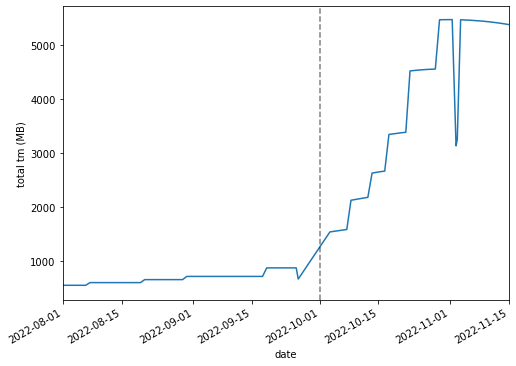

In [3]:
plt.figure(figsize=(8,6))
plt.plot(TM['date'], (TM['tm_rate']*TM['duration'])/8/1e6)#; plt.ylim(0,5000)
plt.xlim(datetime.date(2022,8,1),datetime.date(2022,11,15))
plt.gcf().autofmt_xdate()
plt.axvline(DT(2022,10,1),color='k',linestyle='--',alpha=.5)
# plt.plot(TMnew['date'], np.cumsum(TMnew['tm_rate']*TMnew['duration']));
# plt.ylabel('total tm_rate (bit/s)')
plt.ylabel('total tm (MB)')
plt.xlabel('date')


In [4]:
PHI = PHI_MEMORY(DT(2022,10,4,0,0,0))
TC = 0 # time for cropping
TP = 0 # time for processing
TK = 0 # time for packing
TF = 0 # time for flushing

# SYNOPTIC in LTP-8

None
number of datasets: 96
cadence: 1 mins
duration: 0:01:00
amount of raw-data at 32 bits: 28564.5 MiB, 297.5 MiB per dataset
amount of crop-data at 32 bits: 21972.7 MiB, 228.9 MiB per dataset
cropping time: 1:29:12
processing time: 2 days, 8:00:00
amount of processed data (and intermediate data) at 16 bits: 24902.3 MiB, 30.5 MiB per dataset
compressing (+ flushing) time: 1:59:00.372480
amount of compressed data + metadata at 6 bits: 851.2 MiB, 8.9 MiB per dataset
amount of metadata:  24 MiB
amount of memory usage: 75439.5 MiB



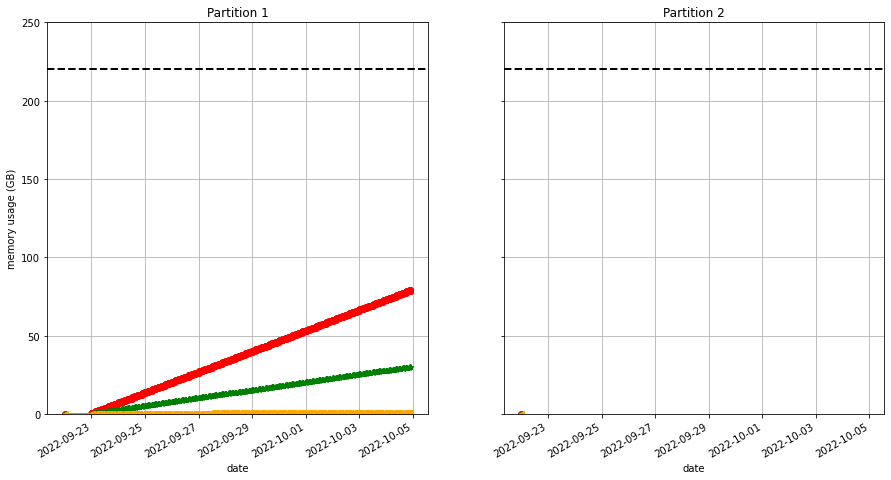

In [5]:
PHI = PHI_MEMORY(DT(2022,9,22,0,0,0))
SYN = PHI_MODE('FDT')
t0 = DT(2022,9,23,0,0,0)
t1 = DT(2022,10,5,0,0,0)
synoptic(SYN,t0,t1,3*60,(2048,1536,4,6),5,6,1,False)
plot_tot(PHI,ylim=(0,250))
printp(SYN)

# <span style="color:blue">CC_OFFPOI_ALIGNMENT</span> <br>
06/10 (12:00 - 20:40)


CC_OFFPOI_ALIGNMENT
number of datasets: 1
cadence: 1 mins
duration: 0:01:00
amount of raw-data at 32 bits: 396.7 MiB, 396.7 MiB per dataset
processing time: 0:35:00
amount of processed data (and intermediate data) at 16 bits: 450.1 MiB, 53.4 MiB per dataset
compressing (+ flushing) time: 0:02:09.429120
amount of compressed data + metadata at 6 bits: 15.4 MiB, 15.4 MiB per dataset
amount of metadata:  16 MiB
amount of memory usage: 846.9 MiB



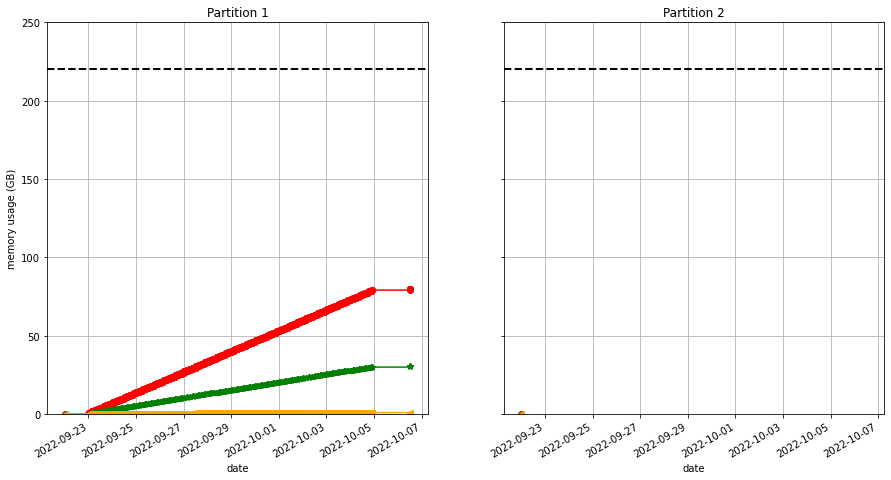

In [6]:
t0 = DT.fromisoformat('2022-10-06T12:00:00')
t1 = DT.fromisoformat('2022-10-06T20:40:00')

CCAL = PHI_MODE('FDT')
synoptic(CCAL,t0,t1,6*60,(2048,2048,4,6),5,6,1,False)
# kw = CCAL.observation(t0,t1,cadence=6*60,shape=(2048,2048,4,6)); PHI.saving(1,**kw)
# kw = CCAL.processing(kw['end'],ndata=-1,partialStore=0x00,nout=5,level='raw',); PHI.saving(1,**kw)
# kw = CCAL.compressing(kw['end'],ndata=-1,nbits=6,level='proc'); PHI.saving(1,**kw)

printp(CCAL,label='CC_OFFPOI_ALIGNMENT')
plot_tot(PHI,ylim=(0,250))

# PHI.format_partition(1,kw['end'] + TD(days=10))
# final_plot(PHI,TM)

# <span style="color:blue">FDT Flat Calibration</span>

FDT Flat Calibration
number of datasets: 10
cadence: 6 mins
duration: 1:01:00
amount of raw-data at 32 bits: 3967.3 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 206.0 MiB, 20.6 MiB per dataset
packing time: 0:01:23.806400
compressing (+ flushing) time: 0:10:04.051776
amount of compressed data + metadata at 6 bits: 72.0 MiB, 72.0 MiB per dataset
amount of metadata:  88 MiB
amount of memory usage: 4173.3 MiB



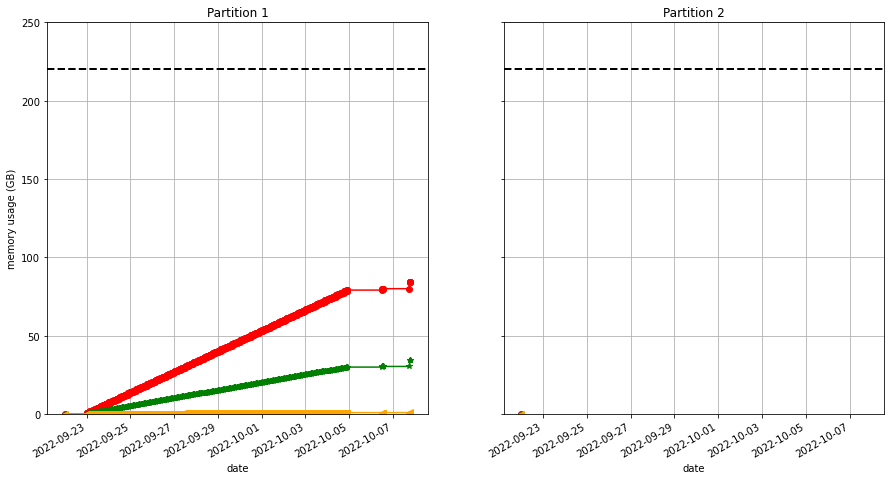

In [7]:
t0 = DT.fromisoformat('2022-10-07T18:00:00')
t1 = DT.fromisoformat('2022-10-07T18:55:00')
FDTf1 = PHI_MODE('FDT')

kw = FDTf1.observation(t0,t1+TD(minutes=6),cadence=6,shape=(2048,2048,4,6)); PHI.saving(1,**kw)
kw = FDTf1.packing(kw['end'],ndata=1,level='raw',); PHI.saving(1,**kw)
kw = FDTf1.compressing(kw['end'],ndata=1,nbits=6,level='raw.pack'); PHI.saving(1,**kw)

########################################################
printp(FDTf1, label='FDT Flat Calibration')
plot_tot(PHI,ylim=(0,250))

# <span style="color:blue">CORONAL DYNAMICSs</span> <br>

Processing and flushing during observation

CORONAL DYNAMICS, no crop, proc
number of datasets: 17
cadence: 1 mins
duration: 0:01:00
amount of raw-data at 32 bits: 6744.4 MiB, 396.7 MiB per dataset
processing time: 9:55:00
amount of processed data (and intermediate data) at 16 bits: 7652.3 MiB, 53.4 MiB per dataset
compressing (+ flushing) time: 0:36:40.295040
amount of compressed data + metadata at 6 bits: 262.3 MiB, 15.4 MiB per dataset
amount of metadata:  16 MiB
amount of memory usage: 14396.7 MiB



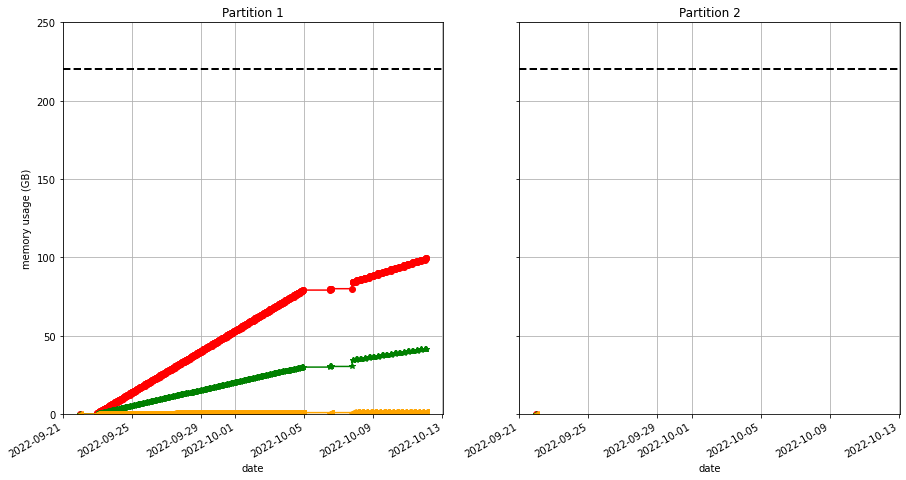

In [8]:
t0 = DT.fromisoformat('2022-10-08T00:00:00')
t1 = DT.fromisoformat('2022-10-12T06:00:00')

M1 = PHI_MODE('FDT')
synoptic(M1,t0,t1,6*60,(2048,2048,4,6),5,6,1,False)
# kw = M1.observation(t0,t1,cadence=6*60,shape=(2048,2048,4,6)); PHI.saving(1,**kw)
# kw = M1.processing(kw['end'],ndata=-1,partialStore=0x00,nout=5,level='raw',); PHI.saving(1,**kw)
# kw = M1.compressing(kw['end'],ndata=-1,nbits=6,level='proc'); PHI.saving(1,**kw)

printp(M1,label='CORONAL DYNAMICS, no crop, proc')
plot_tot(PHI,ylim=(0,250))

# PHI.format_partition(1,kw['end'] + TD(days=10))
# final_plot(PHI,TM)

# <span style="color:blue">RS-burst 1 / CAMPFIRE SOOP</span> <br>

RS-burst 1, 60 datasets, no crop, proc
number of datasets: 24
cadence: 1 mins
duration: 0:24:00
amount of raw-data at 32 bits: 4943.8 MiB, 206.0 MiB per dataset
amount of crop-data at 32 bits: 2563.5 MiB, 106.8 MiB per dataset
cropping time: 0:17:48.432000
amount of pack-data at 16 bits: 1464.8 MiB, 61.0 MiB per dataset
packing time: 0:16:34.598400
compressing (+ flushing) time: 1:00:25.606656
amount of compressed data + metadata at 6 bits: 432.2 MiB, 18.0 MiB per dataset
amount of metadata:  576 MiB
amount of memory usage: 8972.2 MiB



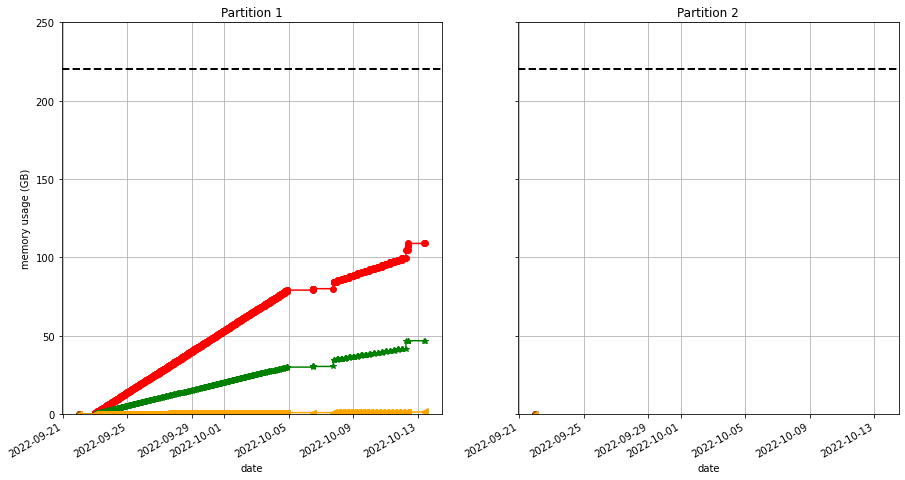

In [9]:
t0 = DT.fromisoformat('2022-10-12T06:00:00')
t1 = DT.fromisoformat('2022-10-12T09:00:00')
i = 1

L1 = PHI_MODE('HRT')
kw = L1.observation(t0,24,cadence=1,shape=(2048,1024,4,6)); PHI.saving(i,**kw)
# kw = L1.observation(kw['end'],kw['end']+TD(hours=2,minutes=50),cadence=5,shape=(2048,2048,4,6)); PHI.saving(1,**kw)
# kw = L1.processing(kw['end'],ndata=-1,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
# kw = L1.compressing(kw['end'],ndata=-1,nbits=6,level='proc'); PHI.saving(i,**kw)

# kw = L1.processing(DT(2022,10,12,9,0,0),ndata=-1,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
kw = L1.cropping(DT(2022,10,12,9,0,0),crop=[1024,1024],ndata=-1,level='raw'); PHI.saving(i,**kw)
kw = L1.packing(kw['end']+TD(minutes=5),ndata=-1,level='raw.crop',); PHI.saving(i,**kw)
kw = L1.compressing(DT(2022,10,13,9,0,0),ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

# TC += (L1.proc.end - L1.proc.start).total_seconds()/60/60
# TF += (L1.compr.end - L1.compr.start).total_seconds()/60/60

printp(L1,label='RS-burst 1, 60 datasets, no crop, proc')
plot_tot(PHI,ylim=(0,250),time_ord=True)

# PHI.format_partition(1,kw['end'] + TD(days=10))
# final_plot(PHI,TM)

# <span style="color:blue">DENSITY FLUCTUACTIONS</span> <br>
12/10 - 13/10 (until 12:00)

Processing and flushing during observation

DENSITY FLUCTUACTIONS, no crop, proc
number of datasets: 4
cadence: 1 mins
duration: 0:01:00
amount of raw-data at 32 bits: 1586.9 MiB, 396.7 MiB per dataset
processing time: 2:20:00
amount of processed data (and intermediate data) at 16 bits: 1800.5 MiB, 53.4 MiB per dataset
compressing (+ flushing) time: 0:08:37.716480
amount of compressed data + metadata at 6 bits: 61.7 MiB, 15.4 MiB per dataset
amount of metadata:  16 MiB
amount of memory usage: 3387.5 MiB



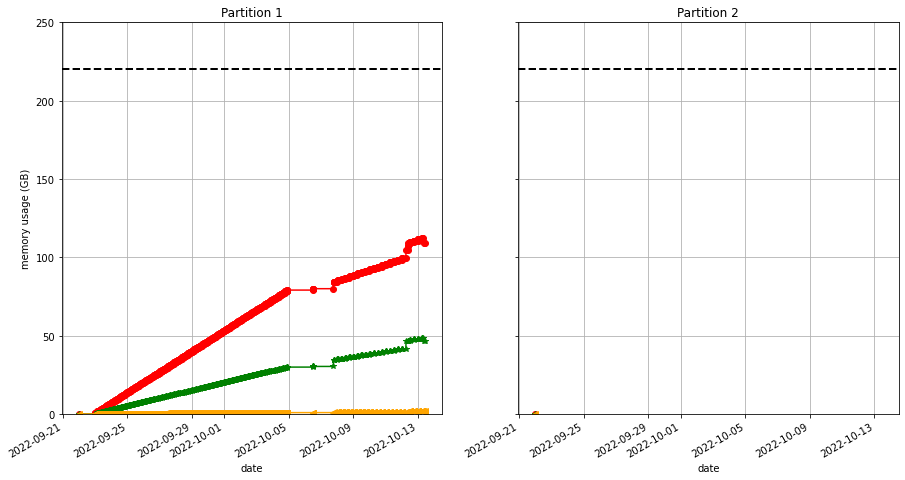

In [10]:
# t0 = DT.fromisoformat('2022-10-12T09:00:00')
t0 = DT.fromisoformat('2022-10-12T12:00:00')
t1 = DT.fromisoformat('2022-10-13T12:00:00')

M2 = PHI_MODE('FDT')
synoptic(M2,t0,t1,6*60,(2048,2048,4,6),5,6,1,False)
# kw = M2.observation(t0,t1,cadence=6*60,shape=(2048,2048,4,6)); PHI.saving(1,**kw)
# kw = M2.processing(kw['end'],ndata=-1,partialStore=0x00,nout=5,level='raw',); PHI.saving(1,**kw)
# kw = M2.compressing(kw['end'],ndata=-1,nbits=6,level='proc'); PHI.saving(1,**kw)

printp(M2,label='DENSITY FLUCTUACTIONS, no crop, proc')
plot_tot(PHI,ylim=(0,250))

# PHI.format_partition(1,kw['end'] + TD(days=10))
# final_plot(PHI,TM)

# <span style="color:blue">RS-burst 2</span> <br>
13/10 (12:00 - 15:00)

30m@1m HRT + 2h30m@5m

No time for processing and flushing

RS-burst 2, 30m@1m + 2h30m@5m, no crop, proc
number of datasets: 60
cadence: 5 mins
duration: 2:30:00
amount of raw-data at 32 bits: 23803.7 MiB, 396.7 MiB per dataset
processing time: 1 day, 11:00:00
amount of processed data (and intermediate data) at 16 bits: 27008.1 MiB, 53.4 MiB per dataset
compressing (+ flushing) time: 2:09:25.747200
amount of compressed data + metadata at 6 bits: 925.7 MiB, 15.4 MiB per dataset
amount of metadata:  336 MiB
amount of memory usage: 50811.8 MiB



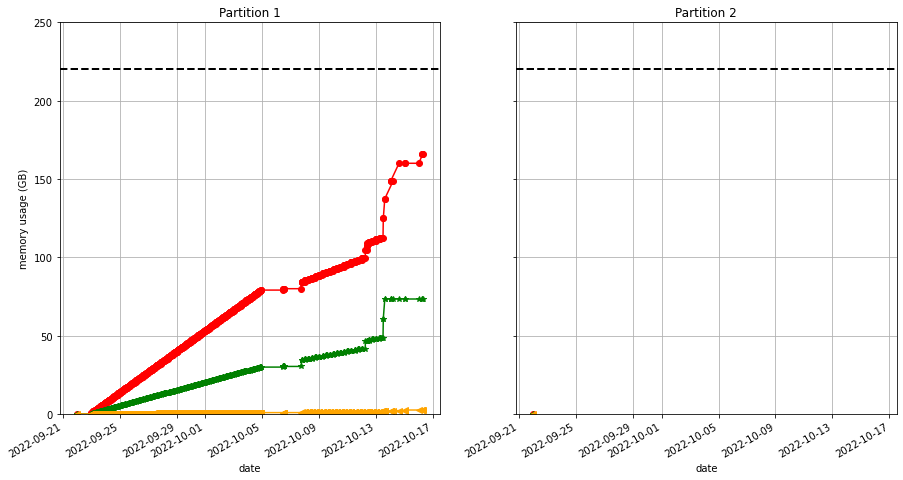

In [11]:
t0 = DT.fromisoformat('2022-10-13T12:00:00')
t1 = DT.fromisoformat('2022-10-13T12:30:00')
i = 1

L2 = PHI_MODE('HRT')
kw = L2.observation(t0,t1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = L2.observation(kw['end'],kw['end']+TD(hours=2,minutes=30),cadence=5,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
# kw = L2.processing(kw['end'],ndata=-1,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
# kw = L2.cropping(kw['end'],[1536,1536],ndata=-1,level='raw'); PHI.saving(i,**kw)
# kw = L2.packing(kw['end'],ndata=-1,level='raw.crop',); PHI.saving(i,**kw)
# kw = L2.compressing(kw['end'],ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

kw = L2.processing(DT(2022,10,13,15,0,0),ndata=24,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
kw = L2.compressing(DT(2022,10,14,1,0,0),ndata=24,nbits=6,level='proc'); PHI.saving(i,**kw)
kw = L2.processing(DT(2022,10,14,1,0,0),ndata=24,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
kw = L2.compressing(DT(2022,10,15,1,0,0),ndata=24,nbits=6,level='proc'); PHI.saving(i,**kw)
kw = L2.processing(DT(2022,10,16,0,0,0),ndata=12,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
kw = L2.compressing(DT(2022,10,16,6,0,0),ndata=12,nbits=6,level='proc'); PHI.saving(i,**kw)

# TC += (L2.proc.end - L2.proc.start).total_seconds()/60/60
# TF += (L2.compr.end - L2.compr.start).total_seconds()/60/60

printp(L2,label='RS-burst 2, 30m@1m + 2h30m@5m, no crop, proc')
plot_tot(PHI,ylim=(0,250),time_ord=True)

# PHI.format_partition(1,kw['end'] + TD(days=10))
# final_plot(PHI,TM)

# <span style="color:blue">CONNECTION MOSAIC</span> <br>
13/10 - 15/10

CONNECTION MOSAIC, no crop, proc
number of datasets: 10
cadence: 1 mins
duration: 0:01:00
amount of raw-data at 32 bits: 3967.3 MiB, 396.7 MiB per dataset
processing time: 5:50:00
amount of processed data (and intermediate data) at 16 bits: 4501.3 MiB, 53.4 MiB per dataset
compressing (+ flushing) time: 0:21:34.291200
amount of compressed data + metadata at 6 bits: 154.3 MiB, 15.4 MiB per dataset
amount of metadata:  16 MiB
amount of memory usage: 8468.6 MiB



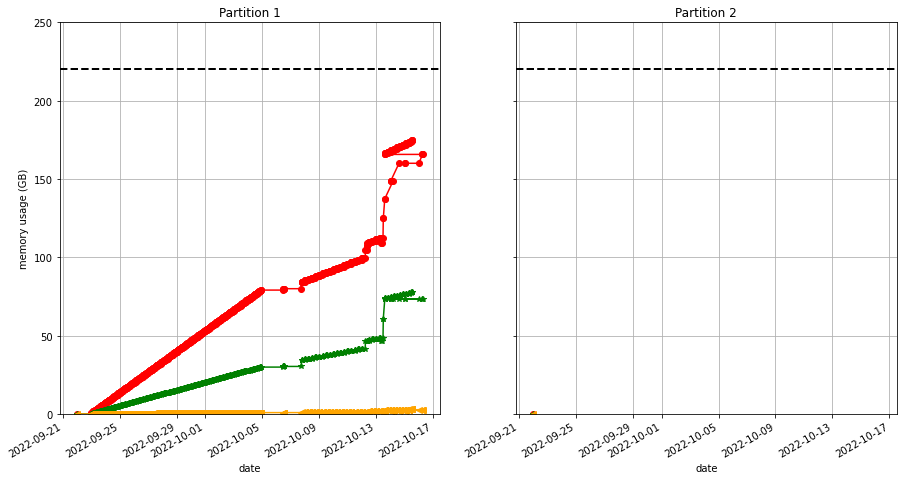

In [12]:
t0 = DT.fromisoformat('2022-10-13T15:00:00')
t1 = t0 + TD(hours=5*10) # DT.fromisoformat('2022-10-15T18:00:00')

CM = PHI_MODE('HRT')
synoptic(CM,t0,t1,5*60,(2048,2048,4,6),5,6,1,False)
# kw = CM.observation(t0,t1,cadence=6*60,shape=(2048,2048,4,6)); PHI.saving(1,**kw)
# kw = CM.processing(kw['end'],ndata=-1,partialStore=0x00,nout=5,level='raw',); PHI.saving(1,**kw)
# kw = CM.compressing(kw['end'],ndata=-1,nbits=6,level='proc'); PHI.saving(1,**kw)

printp(CM,label='CONNECTION MOSAIC, no crop, proc')
plot_tot(PHI,ylim=(0,250))

# PHI.format_partition(1,kw['end'] + TD(days=10))
# final_plot(PHI,TM)

# <span style="color:blue">CC_OFFPOI_OOF</span> <br>
15/10 (from 18:00)

CC_OFFPOI_OOF, 4 datasets, no crop, proc
number of datasets: 3
cadence: 1 mins
duration: 0:01:00
amount of raw-data at 32 bits: 1190.2 MiB, 396.7 MiB per dataset
processing time: 1:45:00
amount of processed data (and intermediate data) at 16 bits: 1350.4 MiB, 53.4 MiB per dataset
compressing (+ flushing) time: 0:06:28.287360
amount of compressed data + metadata at 6 bits: 46.3 MiB, 15.4 MiB per dataset
amount of metadata:  16 MiB
amount of memory usage: 2540.6 MiB



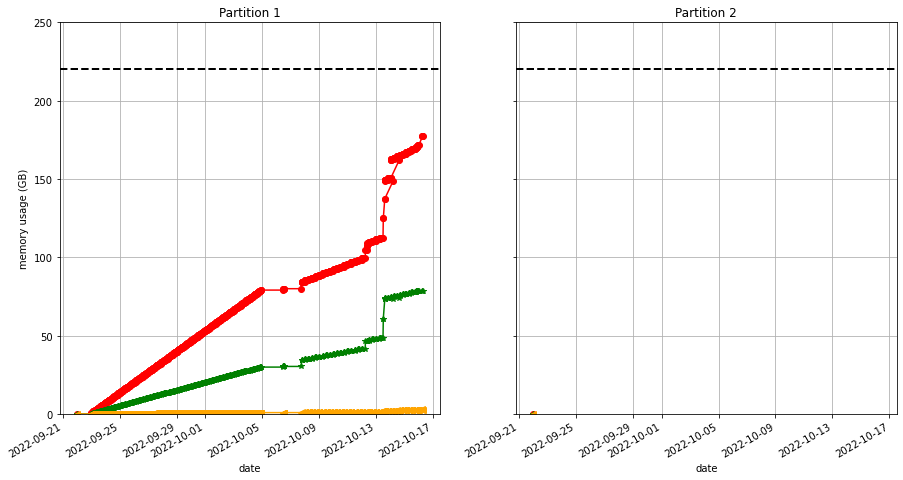

In [13]:
t0 = DT.fromisoformat('2022-10-15T18:00:00')
t1 = DT.fromisoformat('2022-10-16T00:00:00')

CC = PHI_MODE('HRT')
synoptic(CC,t0,t1,2*60,(2048,2048,4,6),5,6,1,False)
# kw = CC.observation(t0,t1,cadence=120,shape=(2048,2048,4,6)); PHI.saving(1,**kw)
# kw = CC.processing(kw['end'],ndata=-1,partialStore=0x00,nout=5,level='raw',); PHI.saving(1,**kw)
# kw = CC.compressing(kw['end'],ndata=-1,nbits=6,level='proc'); PHI.saving(1,**kw)

printp(CC,label='CC_OFFPOI_OOF, 4 datasets, no crop, proc')
plot_tot(PHI,ylim=(0,250),time_ord=True)

# PHI.format_partition(1,kw['end'] + TD(days=10))
# final_plot(PHI,TM)

# <span style="color:blue">POLAR-OBSERVATIONS</span> <br>
16/10 (00:00 - 12:00)

80 datasets (12 hours reserved)


POLAR, 80 datasets, no crop, proc
number of datasets: 24
cadence: 2 mins
duration: 0:48:00
amount of raw-data at 32 bits: 9521.5 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 4943.8 MiB, 206.0 MiB per dataset
packing time: 0:33:31.353600
compressing (+ flushing) time: 4:01:37.242624
amount of compressed data + metadata at 6 bits: 1728.2 MiB, 72.0 MiB per dataset
amount of metadata:  384 MiB
amount of memory usage: 14465.3 MiB



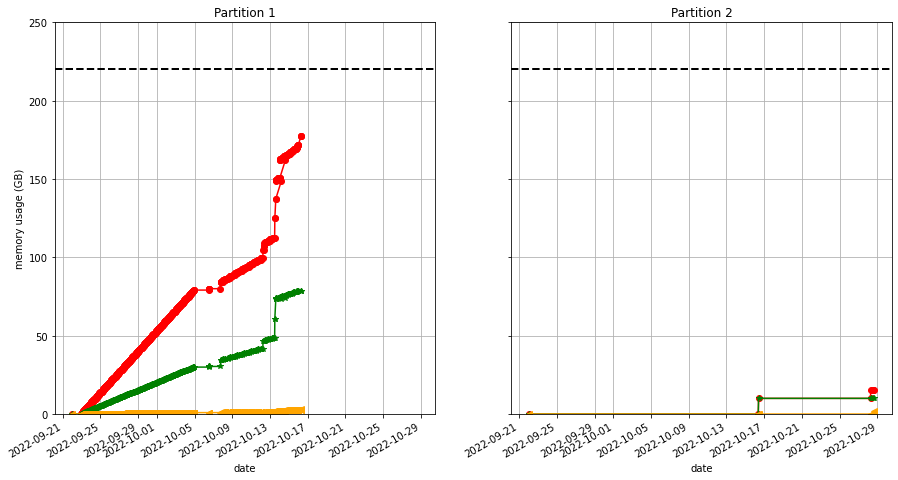

In [14]:
t0 = DT.fromisoformat('2022-10-16T09:00:00')
# t1 = DT.fromisoformat('2022-10-13T13:00:00')
i = 2

PO = PHI_MODE('HRT')
kw = PO.observation(t0,24,cadence=2,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
# kw = PO.processing(kw['end'],ndata=-1,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
# kw = PO.packing(kw['end'],ndata=-1,level='raw'); PHI.saving(i,**kw)
# kw = PO.compressing(kw['end'],ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

kw = PO.packing(DT(2022,10,28,7,0,0),ndata=-1,level='raw'); PHI.saving(i,**kw)
kw = PO.compressing(DT(2022,10,28,13,0,0),ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

# TC += (PO.proc.end - PO.proc.start).total_seconds()/60/60
# TF += (PO.compr.end - PO.compr.start).total_seconds()/60/60

printp(PO,label='POLAR, 80 datasets, no crop, proc')
plot_tot(PHI,ylim=(0,250),time_ord=True)


# <span style="color:magenta">***RESET NAND 1 (?)***</span>

In [15]:
# print('amount of compressed data + metadata in partition 1:',round(PHI.part1.compr*1e6/2**30,2), 'GiB')
# print('amount of compressed data + metadata in partition 2:',round(PHI.part2.compr*1e6/2**30,2), 'GiB')
# tm0 = DT(2022,3,2,0,0,0)
# tm1 = DT(2022,3,15,0,0,0)
# _ = tm_avail(tm0,tm1,df_tm,frac=.2)
# print('amount of compressed data + metadata in partition 2:',round(PHI.part2.compr*1e-3,2), 'GB')
# print('TM time:',round((PHI.part1.compr + PHI.part2.compr)/2151.3,2), 'days')
# PHI.format_partition(1,end + TD(hours=1))
# phi.format_partition(1,end + TD(hours=1))
# phi.format_partition(2,PHI.part2.history['end'][-1] + TD(hours=.5))


print('amount of compressed data + metadata in partition 1:',round(PHI.part1.compr*1e-3,2), 'GB')
PHI.format_partition(1,PHI.part1.history['end'][-1] + TD(hours=.5))


amount of compressed data + metadata in partition 1: 2.96 GB


# <span style="color:blue">AR Long Term</span> <br>
16/10 - 28/10 (from 12:00)

272 datasets

***3 BURSTS FOR ANDREJ SOOP? NO***

AR Long Term, no crop, proc
number of datasets: 96
cadence: 60 mins
duration: 4 days, 0:00:00
amount of raw-data at 32 bits: 38085.9 MiB, 396.7 MiB per dataset
processing time: 2 days, 8:00:00
amount of processed data (and intermediate data) at 16 bits: 43212.9 MiB, 53.4 MiB per dataset
compressing (+ flushing) time: 3:27:05.195520
amount of compressed data + metadata at 6 bits: 1481.2 MiB, 15.4 MiB per dataset
amount of metadata:  816 MiB
amount of memory usage: 81298.8 MiB

Days needed: 13
Exceeding the number of datasets, ndata set to 8
AR Long Term, no crop, raw
number of datasets: 176
cadence: 30 mins
duration: 3 days, 16:00:00
amount of raw-data at 32 bits: 69824.2 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 36254.9 MiB, 206.0 MiB per dataset
packing time: 4:05:49.926400
compressing (+ flushing) time: 1 day, 5:31:53.112576
amount of compressed data + metadata at 6 bits: 12673.5 MiB, 72.0 MiB per dataset
amount of metadata:  2816 MiB
amount of memory usage: 106079.1

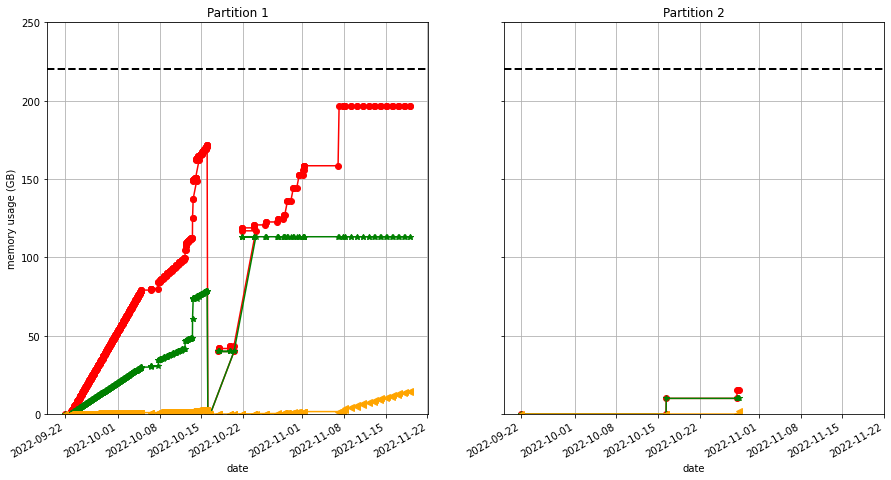

In [16]:
t0 = DT.fromisoformat('2022-10-16T12:00:00')
t1 = DT.fromisoformat('2022-10-27T20:00:00')
i = 1
Nraw = 176

ALp = PHI_MODE('HRT')
kw = ALp.observation(t0,272-Nraw,cadence=60,shape=(2048,2048,4,6)); PHI.saving(i,**kw); t0 = kw['end']

ALr = PHI_MODE('HRT')
kw = ALr.observation(t0,Nraw,cadence=30,shape=(2048,2048,4,6)); PHI.saving(i,**kw)

# kw = ALp.processing(kw['end'],ndata=-1,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
# kw = ALp.compressing(kw['end'],ndata=-1,nbits=6,level='proc'); PHI.saving(i,**kw)
kw = ALp.processing(DT(2022,10,17,19,0,0),ndata=4,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
kw = ALp.compressing(kw['end'],ndata=4,nbits=6,level='proc'); PHI.saving(i,**kw)
kw = ALp.processing(DT(2022,10,19,19,0,0),ndata=4,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
kw = ALp.compressing(kw['end'],ndata=4,nbits=6,level='proc'); PHI.saving(i,**kw)
kw = ALp.processing(DT(2022,10,21,19,0,0),ndata=4,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
kw = ALp.compressing(kw['end'],ndata=4,nbits=6,level='proc'); PHI.saving(i,**kw)
kw = ALp.processing(DT(2022,10,23,19,0,0),ndata=4,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
kw = ALp.compressing(kw['end'],ndata=4,nbits=6,level='proc'); PHI.saving(i,**kw)
kw = ALp.processing(DT(2022,10,25,19,0,0),ndata=4,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
kw = ALp.compressing(kw['end'],ndata=4,nbits=6,level='proc'); PHI.saving(i,**kw)
kw = ALp.processing(DT(2022,10,27,19,0,0),ndata=4,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
kw = ALp.compressing(kw['end'],ndata=4,nbits=6,level='proc'); PHI.saving(i,**kw)

kw = ALp.processing(DT(2022,10,28,19,0,0),ndata=6,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
kw = ALp.compressing(kw['end'],ndata=6,nbits=6,level='proc'); PHI.saving(i,**kw)

kw = ALp.processing(DT(2022,10,29,1,0,0),ndata=18,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
kw = ALp.compressing(kw['end'],ndata=18,nbits=6,level='proc'); PHI.saving(i,**kw)

kw = ALp.processing(DT(2022,10,30,1,0,0),ndata=18,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
kw = ALp.compressing(kw['end'],ndata=18,nbits=6,level='proc'); PHI.saving(i,**kw)

kw = ALp.processing(DT(2022,10,31,1,0,0),ndata=18,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
kw = ALp.compressing(kw['end'],ndata=18,nbits=6,level='proc'); PHI.saving(i,**kw)

kw = ALp.processing(DT(2022,11,1,1,0,0),ndata=6,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
kw = ALp.compressing(kw['end'],ndata=6,nbits=6,level='proc'); PHI.saving(i,**kw)

kw = ALp.processing(DT(2022,11,1,2,0,0),ndata=6,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
kw = ALp.compressing(kw['end'],ndata=6,nbits=6,level='proc'); PHI.saving(i,**kw)

# kw = ALp.processing(DT(2022,11,1,3,0,0),ndata=12,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
# kw = ALp.compressing(kw['end'],ndata=6,nbits=6,level='proc'); PHI.saving(i,**kw)

# kw = ALp.processing(DT(2022,11,1,4,0,0),ndata=12,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
# kw = ALp.compressing(kw['end'],ndata=6,nbits=6,level='proc'); PHI.saving(i,**kw)

TC += (ALp.proc.end - ALp.proc.start).total_seconds()/60/60
TF += (ALp.compr.end - ALp.compr.start).total_seconds()/60/60

printp(ALp,label='AR Long Term, no crop, proc')

kw = ALr.packing(DT(2022,11,7,0,0),ndata=-1,level='raw',); PHI.saving(i,**kw)
ALr, kw = flush_many([1100,1100],72,ALr,DT(2022,11,7,18,0,0),6,-1,'raw.pack',i)
# kw = ALr.compressing(kw['end'],ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

TK += (ALr.raw.pack.end - ALr.raw.pack.start).total_seconds()/60/60
TF += (ALr.compr.pack.end - ALr.compr.pack.start).total_seconds()/60/60

printp(ALr,label='AR Long Term, no crop, raw')

plot_tot(PHI,ylim=(0,250),time_ord=True)

# <span style="color:blue">ATMOSPHERIC-DYNIMICS-STRUCTURE 1</span> <br>
27/10 (20:00-24:00)


Days needed: 6
Exceeding the number of datasets, ndata set to 5
AR-HRES-RSW1, 2d@10m, no crop, proc
number of datasets: 240
cadence: 1 mins
duration: 4:00:00
amount of raw-data at 32 bits: 49438.5 MiB, 206.0 MiB per dataset
amount of crop-data at 32 bits: 25634.8 MiB, 106.8 MiB per dataset
cropping time: 2:58:04.320000
amount of pack-data at 16 bits: 14648.4 MiB, 61.0 MiB per dataset
packing time: 2:45:45.984000
compressing (+ flushing) time: 10:04:16.066560
amount of compressed data + metadata at 6 bits: 4322.1 MiB, 18.0 MiB per dataset
amount of metadata:  5760 MiB
amount of memory usage: 89721.7 MiB



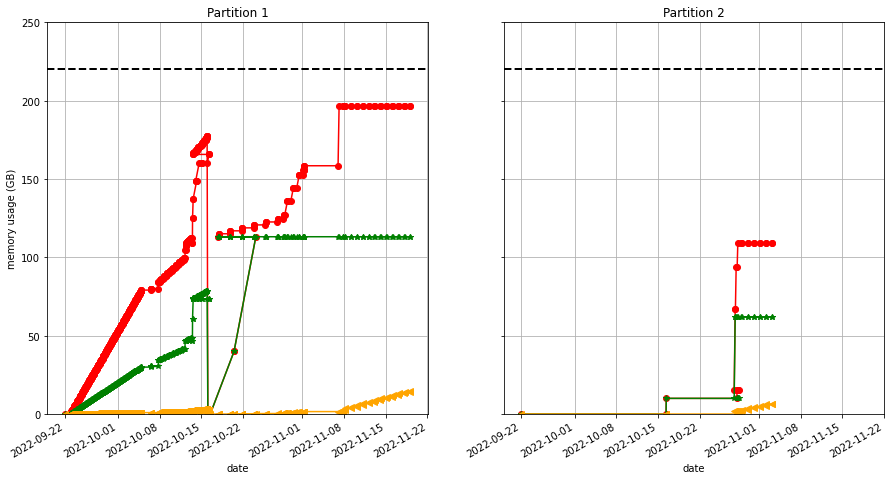

In [17]:
t0 = DT.fromisoformat('2022-10-27T20:00:00')
t1 = DT.fromisoformat('2022-10-28T00:00:00')
i = 2

ADS1 = PHI_MODE('HRT')
kw = ADS1.observation(t0,t1,cadence=1,shape=(2048,1024,4,6)); PHI.saving(i,**kw)
# kw = ADS1.cropping(t0,[1024,1024],ndata=-1,level='raw'); PHI.saving(i,**kw)
# kw = ADS1.packing(kw['end'],ndata=-1,level='raw.crop',); PHI.saving(i,**kw)
# kw = ADS1.compressing(kw['end'],ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

kw = ADS1.cropping(DT(2022,10,28,1,0,0),[1024,1024],ndata=-1,level='raw'); PHI.saving(i,**kw)
kw = ADS1.packing(DT(2022,10,28,8,0,0),ndata=-1,level='raw.crop',); PHI.saving(i,**kw)


ADS1, kw = flush_many([880,880],18,ADS1,DT(2022,10,29,0,0,0),6,-1,'raw.pack',i)
printp(ADS1,label='AR-HRES-RSW1, 2d@10m, no crop, proc')
plot_tot(PHI,ylim=(0,250))


# <span style="color:blue">CH-BOUNDARY-EXPANSION</span> <br>
28/10

Processing and flushing during observation

20h free for flush all data in partition 1

CH-BOUNDARY-EXPANSION, no crop, proc
number of datasets: 4
cadence: 1 mins
duration: 0:01:00
amount of raw-data at 32 bits: 1190.2 MiB, 297.5 MiB per dataset
amount of crop-data at 32 bits: 915.5 MiB, 228.9 MiB per dataset
cropping time: 0:03:43
processing time: 2:20:00
amount of processed data (and intermediate data) at 16 bits: 1007.1 MiB, 22.9 MiB per dataset
compressing (+ flushing) time: 0:02:58.509312
amount of compressed data + metadata at 6 bits: 21.3 MiB, 5.3 MiB per dataset
amount of metadata:  24 MiB
amount of memory usage: 3112.8 MiB



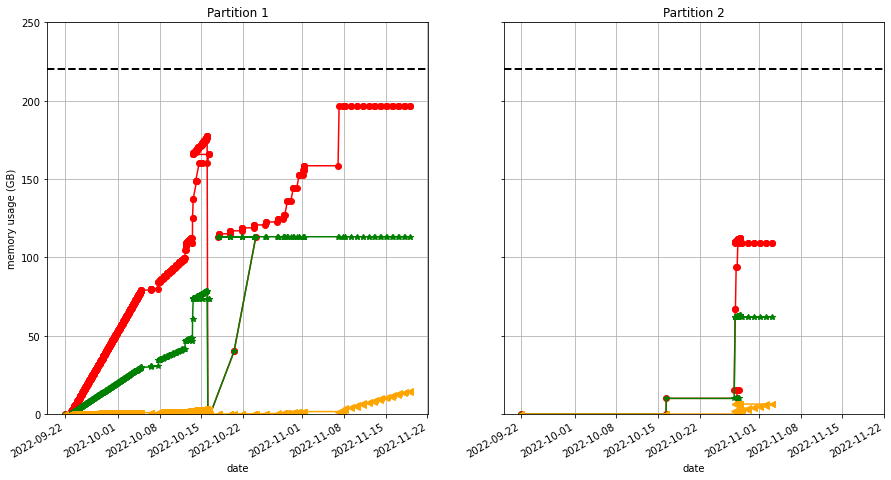

In [18]:
t0 = DT.fromisoformat('2022-10-28T00:00:00')
t1 = DT.fromisoformat('2022-10-29T00:00:00')
i = 2

M3 = PHI_MODE('FDT')
synoptic(M3,t0,t1,6*60,(2048,1536,4,6),3,6,i,False)
# kw = M2.observation(t0,t1,cadence=6*60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
# kw = M2.processing(kw['end'],ndata=-1,partialStore=0x00,nout=5,level='raw'); PHI.saving(i,**kw)
# kw = M2.compressing(kw['end'],ndata=-1,nbits=6,level='proc'); PHI.saving(i,**kw)

printp(M3,label='CH-BOUNDARY-EXPANSION, no crop, proc')
plot_tot(PHI,ylim=(0,250))

# PHI.format_partition(1,kw['end'] + TD(days=10))
# final_plot(PHI,TM)

# <span style="color:blue">ERUPTION WATCH 1-7</span> <br>
FROM 29/10, 8 DAYAS WITH BREAKS

ERUPTION WATCH, 7 SOOPS, no crop, proc
number of datasets: 24
cadence: 1 mins
duration: 0:01:00
amount of raw-data at 32 bits: 7141.1 MiB, 297.5 MiB per dataset
amount of crop-data at 32 bits: 5493.2 MiB, 228.9 MiB per dataset
cropping time: 0:22:18
processing time: 14:00:00
amount of processed data (and intermediate data) at 16 bits: 6042.5 MiB, 22.9 MiB per dataset
compressing (+ flushing) time: 0:17:51.055872
amount of compressed data + metadata at 6 bits: 127.7 MiB, 5.3 MiB per dataset
amount of metadata:  24 MiB
amount of memory usage: 18676.8 MiB



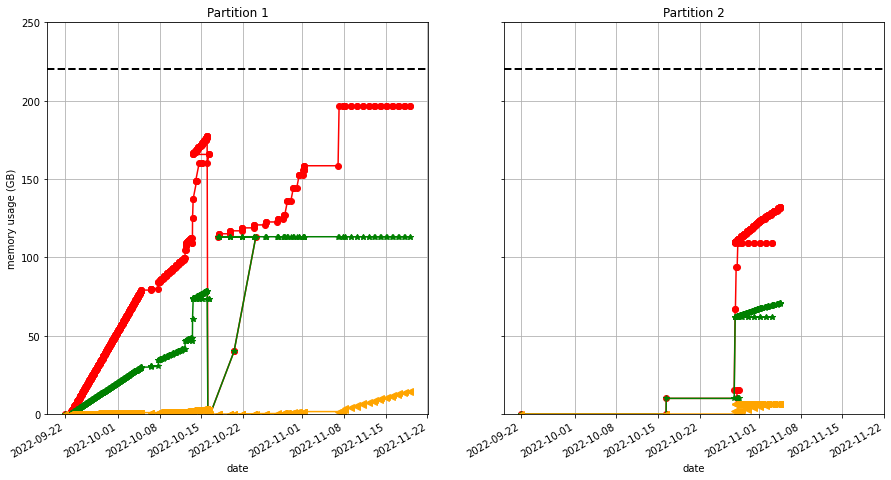

In [19]:
t0 = DT.fromisoformat('2022-10-29T00:00:00')
t1 = DT.fromisoformat('2022-10-30T00:00:00')
i = 2

M4 = PHI_MODE('FDT')
synoptic(M4,t0,t1,6*60,(2048,1536,4,6),3,6,i,False)

t0 = DT.fromisoformat('2022-10-30T00:00:00')
t1 = DT.fromisoformat('2022-10-31T00:00:00')
synoptic(M4,t0,t1,6*60,(2048,1536,4,6),3,6,i,False)

t0 = DT.fromisoformat('2022-10-31T00:00:00')
t1 = DT.fromisoformat('2022-11-01T00:00:00')
synoptic(M4,t0,t1,6*60,(2048,1536,4,6),3,6,i,False)

t0 = DT.fromisoformat('2022-11-01T00:00:00')
t1 = DT.fromisoformat('2022-11-01T18:00:00')
synoptic(M4,t0,t1,6*60,(2048,1536,4,6),3,6,i,False)

t0 = DT.fromisoformat('2022-11-02T00:00:00')
t1 = DT.fromisoformat('2022-11-02T18:00:00')
synoptic(M4,t0,t1,6*60,(2048,1536,4,6),3,6,i,False)

t0 = DT.fromisoformat('2022-11-03T00:00:00')
t1 = DT.fromisoformat('2022-11-03T19:00:00')
synoptic(M4,t0,t1,6*60,(2048,1536,4,6),3,6,i,False)

t0 = DT.fromisoformat('2022-11-04T00:00:00')
t1 = DT.fromisoformat('2022-11-04T18:00:00')
synoptic(M4,t0,t1,6*60,(2048,1536,4,6),3,6,i,False)

# kw = M3.observation(t0,t1,cadence=6*60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
# kw = M3.processing(kw['end'],ndata=-1,partialStore=0x00,nout=5,level='raw'); PHI.saving(i,**kw)
# kw = M3.compressing(kw['end'],ndata=-1,nbits=6,level='proc'); PHI.saving(i,**kw)

printp(M4,label='ERUPTION WATCH, 7 SOOPS, no crop, proc')
plot_tot(PHI,ylim=(0,250))

# PHI.format_partition(1,kw['end'] + TD(days=10))
# final_plot(PHI,TM)

# <span style="color:blue">AR_HEATING</span> <br>
29-31/10 (22:00-24:00)
3 bursts

AR_HEATING, 6h@1m, no crop, raw
number of datasets: 6
cadence: 30 mins
duration: 1:00:00
amount of raw-data at 32 bits: 2380.4 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 1236.0 MiB, 206.0 MiB per dataset
packing time: 0:08:22.838400
compressing (+ flushing) time: 1:00:24.310656
amount of compressed data + metadata at 6 bits: 432.1 MiB, 72.0 MiB per dataset
amount of metadata:  32 MiB
amount of memory usage: 3616.3 MiB



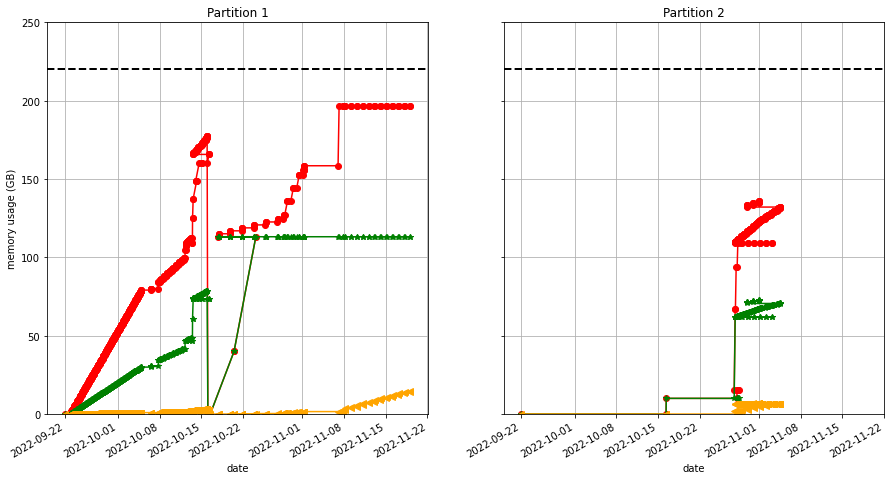

In [20]:
t0 = DT.fromisoformat('2022-10-29T22:30:00')
t1 = DT.fromisoformat('2022-10-29T23:30:00')
i = 2

ARH = PHI_MODE('HRT')
kw = ARH.observation(t0,t1,cadence=30,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = ARH.packing(kw['end'],ndata=2,level='raw',); PHI.saving(i,**kw)
kw = ARH.compressing(kw['end'],ndata=2,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

kw = ARH.observation(t0+TD(days=1),t1+TD(days=1),cadence=30,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = ARH.packing(kw['end'],ndata=2,level='raw',); PHI.saving(i,**kw)
kw = ARH.compressing(kw['end'],ndata=2,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

kw = ARH.observation(t0+TD(days=2),t1+TD(days=2),cadence=30,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = ARH.packing(kw['end'],ndata=2,level='raw',); PHI.saving(i,**kw)
kw = ARH.compressing(kw['end'],ndata=2,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

# kw = ARH.cropping(t0,[1024,1024],ndata=-1,level='raw'); PHI.saving(i,**kw)
# kw = ARH.packing(kw['end'],ndata=-1,level='raw',); PHI.saving(i,**kw)
# kw = ARH.compressing(kw['end'],ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

printp(ARH,label='AR_HEATING, 6h@1m, no crop, raw')
plot_tot(PHI,ylim=(0,250))


# <span style="color:blue">AR_SUSANNA 1</span> <br>
1-3/11 (12:00-24:00)
3 runs

AR_SUSANNA 1, no crop, raw
number of datasets: 30
cadence: 60 mins
duration: 10:00:00
amount of raw-data at 32 bits: 11901.9 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 6179.8 MiB, 206.0 MiB per dataset
packing time: 0:41:54.192000
compressing (+ flushing) time: 5:02:01.553280
amount of compressed data + metadata at 6 bits: 2160.3 MiB, 72.0 MiB per dataset
amount of metadata:  160 MiB
amount of memory usage: 18081.7 MiB



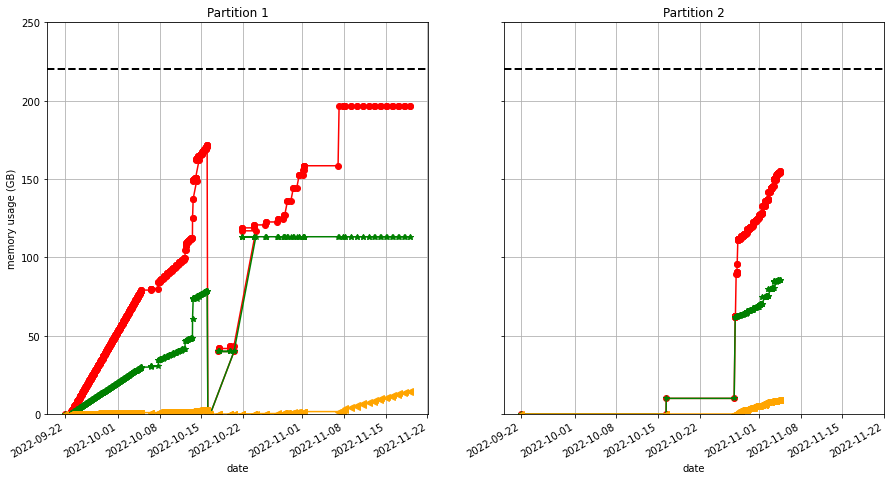

In [21]:
t0 = DT.fromisoformat('2022-11-01T12:30:00')
t1 = DT.fromisoformat('2022-11-01T22:30:00')
i = 2

ARS1 = PHI_MODE('HRT')
kw = ARS1.observation(t0,t1,cadence=60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
# kw = ARS1.observation(t0+TD(days=1),t1+TD(days=1),cadence=60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
# kw = ARS1.observation(t0+TD(days=2),t1+TD(days=2),cadence=60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
# kw = ARS1.cropping(t0,[1024,1024],ndata=-1,level='raw'); PHI.saving(i,**kw)
kw = ARS1.packing(kw['end'],ndata=-1,level='raw',); PHI.saving(i,**kw)
kw = ARS1.compressing(kw['end'],ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

t0 = DT.fromisoformat('2022-11-02T12:30:00')
t1 = DT.fromisoformat('2022-11-02T22:30:00')

kw = ARS1.observation(t0,t1,cadence=60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
# kw = ARS1.observation(t0+TD(days=1),t1+TD(days=1),cadence=60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
# kw = ARS1.observation(t0+TD(days=2),t1+TD(days=2),cadence=60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
# kw = ARS1.cropping(t0,[1024,1024],ndata=-1,level='raw'); PHI.saving(i,**kw)
kw = ARS1.packing(kw['end'],ndata=-1,level='raw',); PHI.saving(i,**kw)
kw = ARS1.compressing(kw['end'],ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

t0 = DT.fromisoformat('2022-11-03T12:30:00')
t1 = DT.fromisoformat('2022-11-03T22:30:00')

kw = ARS1.observation(t0,t1,cadence=60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
# kw = ARS1.observation(t0+TD(days=1),t1+TD(days=1),cadence=60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
# kw = ARS1.observation(t0+TD(days=2),t1+TD(days=2),cadence=60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
# kw = ARS1.cropping(t0,[1024,1024],ndata=-1,level='raw'); PHI.saving(i,**kw)
kw = ARS1.packing(kw['end'],ndata=-1,level='raw',); PHI.saving(i,**kw)
kw = ARS1.compressing(kw['end'],ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

printp(ARS1,label='AR_SUSANNA 1, no crop, raw')
plot_tot(PHI,ylim=(0,250),time_ord=True)


# <span style="color:magenta">***RESET NAND 2 (?)***</span>

In [22]:
print('amount of compressed data + metadata in partition 2:',round(PHI.part2.compr*1e-3,2), 'GB')
PHI.format_partition(2,DT(2022,11,4,6,0,0))

amount of compressed data + metadata in partition 2: 9.22 GB


# <span style="color:blue">ATMOSPHERIC-DYNIMICS-STRUCTURE 2</span> <br>
4/11 (12:00-24:00)


Days needed: 26
Exceeding the number of datasets, ndata set to 10
ATMOSPHERIC-DYNIMICS-STRUCTURE 2, no crop, raw
number of datasets: 360
cadence: 1 mins
duration: 6:00:00
amount of raw-data at 32 bits: 142822.3 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 74157.7 MiB, 206.0 MiB per dataset
packing time: 8:22:50.304000
compressing (+ flushing) time: 2 days, 12:24:18.639360
amount of compressed data + metadata at 6 bits: 25923.1 MiB, 72.0 MiB per dataset
amount of metadata:  5760 MiB
amount of memory usage: 216980.0 MiB



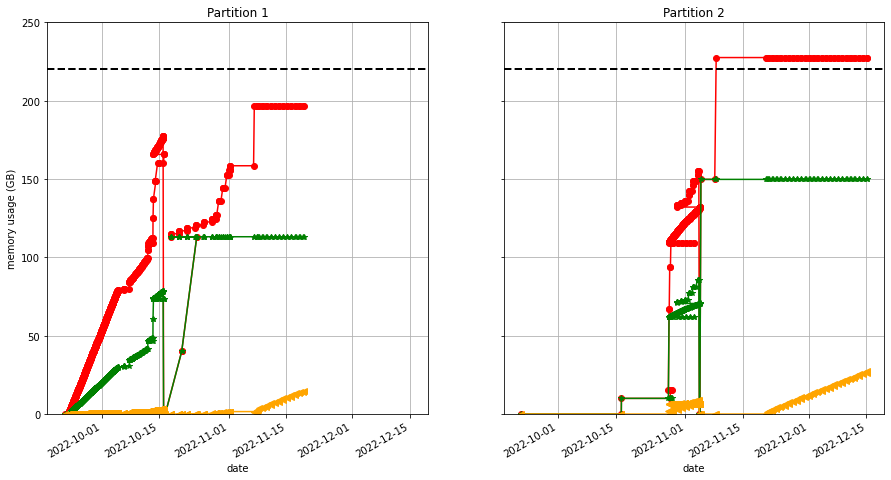

In [23]:
t0 = DT.fromisoformat('2022-11-04T12:00:00')
t1 = DT.fromisoformat('2022-11-05T00:00:00')
i = 2

ADS2 = PHI_MODE('HRT')
kw = ADS2.observation(t0,60*6,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
# kw = ADS2.cropping(t0,[1024,1024],ndata=-1,level='raw'); PHI.saving(i,**kw)
# kw = ADS2.packing(kw['end'],ndata=-1,level='raw',); PHI.saving(i,**kw)
# kw = ADS2.compressing(kw['end'],ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

kw = ADS2.packing(DT(2022,11,8,3,0,0),ndata=-1,level='raw',); PHI.saving(i,**kw)
ADS2, kw = flush_many([1100,1100],72,ADS2,DT(2022,11,20,17,0,0),ndata=-1,nbits=6,level='raw.pack',partition=i)

printp(ADS2,label='ATMOSPHERIC-DYNIMICS-STRUCTURE 2, no crop, raw')
plot_tot(PHI,ylim=(0,250))


# <span style="color:blue">ERUPTION WATCH 8</span> <br>
5-6/11

ERUPTION WATCH, 8th SOOPS, no crop, raw
number of datasets: 5
cadence: 1 mins
duration: 0:01:00
amount of raw-data at 32 bits: 1487.7 MiB, 297.5 MiB per dataset
amount of crop-data at 32 bits: 1144.4 MiB, 228.9 MiB per dataset
cropping time: 0:04:38.750000
amount of pack-data at 16 bits: 610.4 MiB, 122.1 MiB per dataset
packing time: 0:04:55.468000
compressing (+ flushing) time: 0:28:19.053120
amount of compressed data + metadata at 6 bits: 202.5 MiB, 40.5 MiB per dataset
amount of metadata:  24 MiB
amount of memory usage: 3242.5 MiB



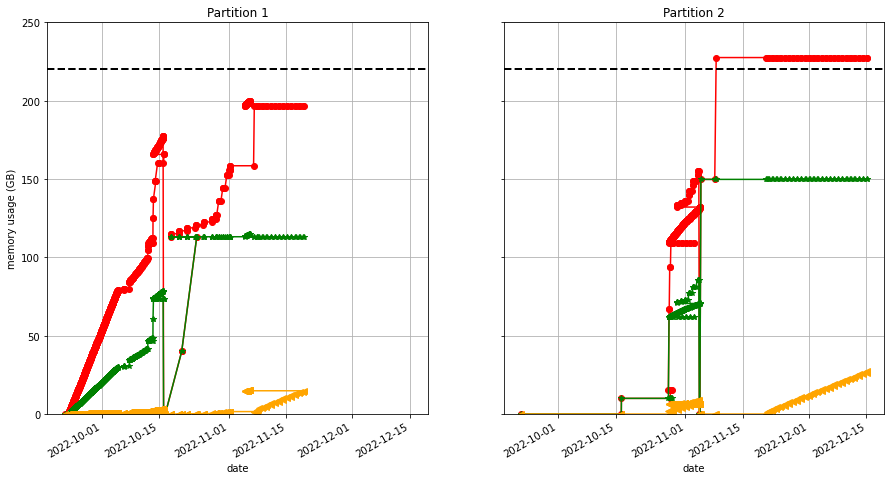

In [24]:
t0 = DT.fromisoformat('2022-11-05T00:00:00')
t1 = DT.fromisoformat('2022-11-06T06:00:00')
i = 1

M4r = PHI_MODE('FDT')
synoptic_raw(M4r,t0,t1,6*60,(2048,1536,4,6),6,i,False)

printp(M4r,label='ERUPTION WATCH, 8th SOOPS, no crop, raw')
plot_tot(PHI,ylim=(0,250))


# <span style="color:blue">AR_SUSANNA 2</span> <br>
6/11 (04:30-11:30)


AR_SUSANNA 2, no crop, raw
number of datasets: 7
cadence: 60 mins
duration: 7:00:00
amount of raw-data at 32 bits: 2777.1 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 1442.0 MiB, 206.0 MiB per dataset
packing time: 0:09:46.644800
compressing (+ flushing) time: 1:10:28.362432
amount of compressed data + metadata at 6 bits: 504.1 MiB, 72.0 MiB per dataset
amount of metadata:  112 MiB
amount of memory usage: 4219.1 MiB



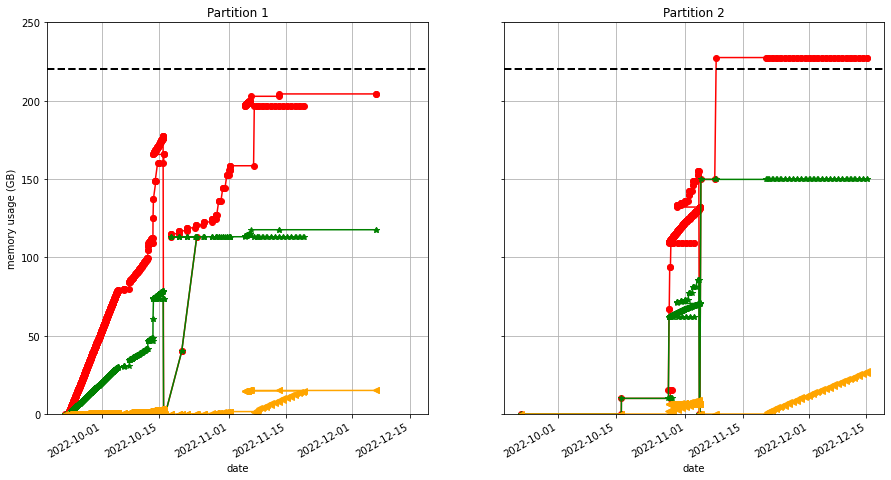

In [25]:
t0 = DT.fromisoformat('2022-11-06T04:30:00')
t1 = DT.fromisoformat('2022-11-06T11:30:00')
i = 1

ARH = PHI_MODE('HRT')
kw = ARH.observation(t0,t1,cadence=60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
# kw = ARH.cropping(t0,[1024,1024],ndata=-1,level='raw'); PHI.saving(i,**kw)
# kw = ARH.packing(kw['end'],ndata=-1,level='raw',); PHI.saving(i,**kw)
# kw = ARH.compressing(kw['end'],ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

kw = ARH.packing(DT(2022,11,13,3,0,0),ndata=-1,level='raw',); PHI.saving(i,**kw)
kw = ARH.compressing(DT(2022,12,6,17,0,0),ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

TK += (ARH.raw.pack.end - ARH.raw.pack.start).total_seconds()/60/60
TF += (ARH.compr.pack.end - ARH.compr.pack.start).total_seconds()/60/60

printp(ARH,label='AR_SUSANNA 2, no crop, raw')
plot_tot(PHI,ylim=(0,250))


# <span style="color:blue">CRAZY MOSAIC</span> <br>
6/11
36 datasets

Days needed: 3
Exceeding the number of datasets, ndata set to 8
Crazy Mosaic, 36 datasets, no crop, proc
number of datasets: 36
cadence: 7 mins
duration: 4:12:00
amount of raw-data at 32 bits: 14282.2 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 7415.8 MiB, 206.0 MiB per dataset
packing time: 0:50:17.030400
compressing (+ flushing) time: 6:02:25.863936
amount of compressed data + metadata at 6 bits: 2592.3 MiB, 72.0 MiB per dataset
amount of metadata:  576 MiB
amount of memory usage: 21698.0 MiB



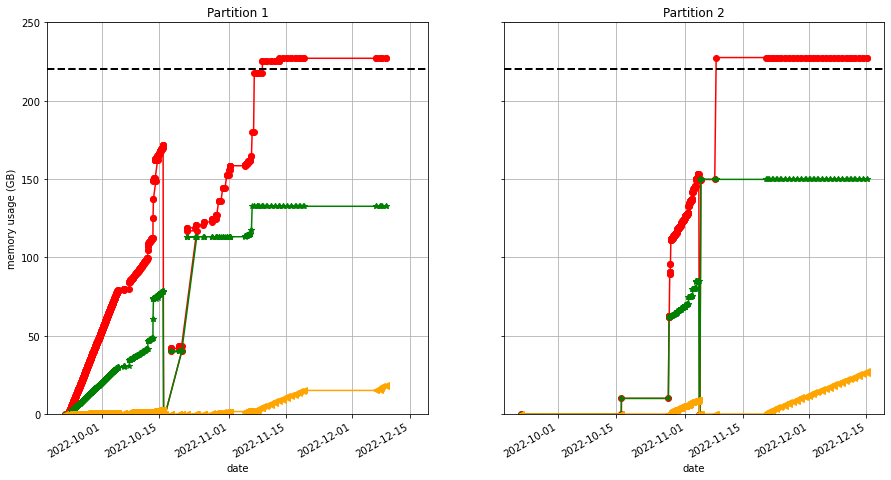

In [26]:
t0 = DT.fromisoformat('2022-11-06T11:30:00')
# t1 = t0 + TD(minutes=175) #36 datasets
i = 1

CM = PHI_MODE('HRT')
kw = CM.observation(t0,36,cadence=7,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
# kw = CM.packing(kw['end'],ndata=-1,level='raw',); PHI.saving(i,**kw)
# kw = CM.compressing(kw['end'],ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

kw = CM.packing(DT(2022,11,9,3,0,0),ndata=-1,level='raw',); PHI.saving(i,**kw)
CM, kw = flush_many([1100,1100],72,CM,DT(2022,12,7,17,0,0),ndata=-1,nbits=6,level='raw.pack',partition=i)

TK += (CM.raw.pack.end - CM.raw.pack.start).total_seconds()/60/60
TF += (CM.compr.pack.end - CM.compr.pack.start).total_seconds()/60/60

printp(CM,label='Crazy Mosaic, 36 datasets, no crop, proc')
plot_tot(PHI,ylim=(0,250),time_ord=True)


# <span style="color:blue">BRIGHT POINTS</span> <br>
6/11 (16:00 - 24:35)

Days needed: 1
Exceeding the number of datasets, ndata set to 25
Bright Points, no crop, proc
number of datasets: 25
cadence: 20 mins
duration: 8:35:00
amount of raw-data at 32 bits: 7438.7 MiB, 297.5 MiB per dataset
amount of crop-data at 32 bits: 5722.0 MiB, 228.9 MiB per dataset
cropping time: 0:23:13.750000
amount of pack-data at 16 bits: 3051.8 MiB, 122.1 MiB per dataset
packing time: 0:24:37.340000
compressing (+ flushing) time: 2:21:35.265600
amount of compressed data + metadata at 6 bits: 1012.7 MiB, 40.5 MiB per dataset
amount of metadata:  600 MiB
amount of memory usage: 16212.5 MiB



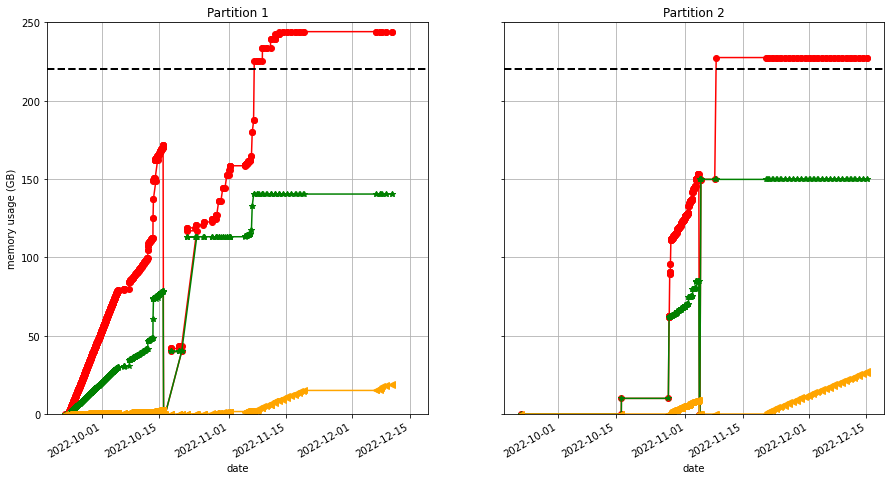

In [27]:
t0 = DT.fromisoformat('2022-11-06T16:00:00')
t1 = DT.fromisoformat('2022-11-07T00:35:00')
i = 1

BP = PHI_MODE('HRT')
kw = BP.observation(t0,t1,cadence=20,shape=(2048,1536,4,6)); PHI.saving(i,**kw)
# kw = BP.cropping(t0,[1536,1536],ndata=-1,level='raw'); PHI.saving(i,**kw)
# kw = BP.packing(kw['end'],ndata=-1,level='raw.crop',); PHI.saving(i,**kw)
# kw = BP.compressing(kw['end'],ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

kw = BP.cropping(DT(2022,11,11,3,0,0),[1536,1536],ndata=-1,level='raw'); PHI.saving(i,**kw)
kw = BP.packing(DT(2022,11,12,3,0,0),ndata=-1,level='raw.crop',); PHI.saving(i,**kw)
BP, kw = flush_many([1100,1100],40.5,BP,DT(2022,12,10,17,0,0),ndata=-1,nbits=6,level='raw.pack',partition=i)

TK += (BP.raw.pack.end - BP.raw.pack.start).total_seconds()/60/60
TF += (BP.compr.pack.end - BP.compr.pack.start).total_seconds()/60/60

printp(BP,label='Bright Points, no crop, proc')
plot_tot(PHI,ylim=(0,250),time_ord=True)


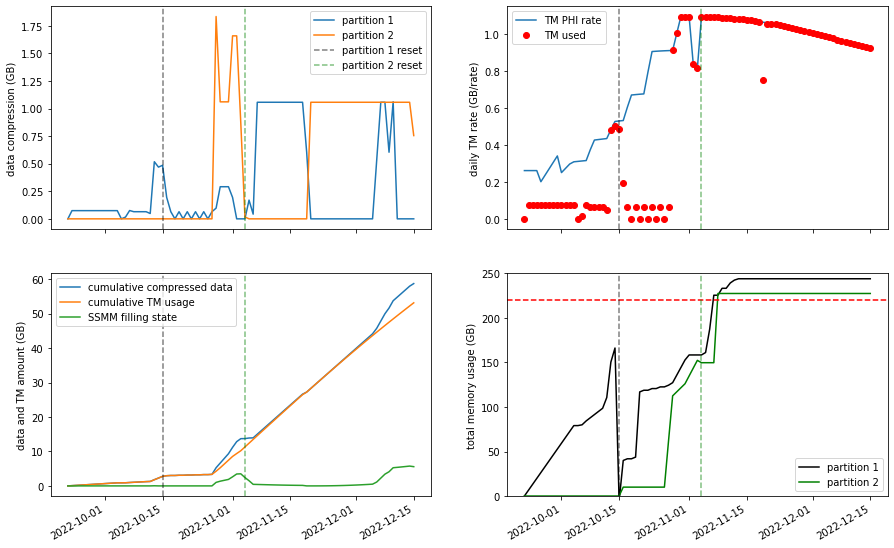

In [28]:
final_plot(PHI,TM)

/tmp/ipykernel_283726/3875396231.py:153: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
/tmp/ipykernel_283726/3875396231.py:160: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(122)


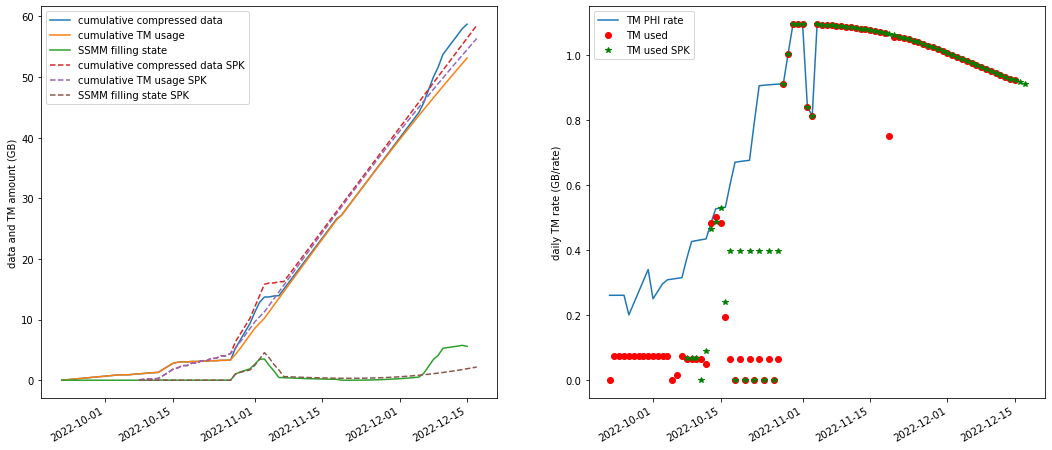

In [29]:
from scipy.interpolate import interp1d
tot1 = np.asarray(PHI.part1.history['occu'])
tot2 = np.asarray(PHI.part2.history['occu'])
c1 = np.asarray(PHI.part1.history['compr'])
c2 = np.asarray(PHI.part2.history['compr'])
d1 = np.asarray(PHI.part1.history['start'])
d2 = np.asarray(PHI.part2.history['start'])

starttime = min(d1[0],d2[0])
endtime = max(d1[-1],d2[-1])
t0 = starttime
times = []
while starttime.date() <= endtime.date():
    times.append(starttime.date())
    starttime += datetime.timedelta(days=1)
starttime = t0; del t0
times_float = [(t - d1[0]).total_seconds() for t in d1]
times = np.asarray(times)

s = np.argsort(d1)

newtot1 = np.zeros(np.size(times))
for i,j in zip(d1,tot1):
    if True:
        ind = np.where(times == i.date())[0]
        newtot1[ind] += j/1e3
newtot1 = np.asarray(newtot1)

newtot2 = np.zeros(np.size(times))
for i,j in zip(d2,tot2):
    if True:
        ind = np.where(times == i.date())[0]
        newtot2[ind] += j/1e3
newtot2 = np.asarray(newtot2)

newc1 = np.zeros(np.size(times))
for i,j in zip(d1,c1):
    if j>=0:
        ind = np.where(times == i.date())[0]
        newc1[ind] += j/1e3
newc1 = np.asarray(newc1)


newc2 = np.zeros(np.size(times))
for i,j in zip(d2,c2):
    if j>=0:
        ind = np.where(times == i.date())[0]
        newc2[ind] += j/1e3
newc2 = np.asarray(newc2)

form1 = np.zeros(np.size(times))
for i,j in zip(d1,c1):
    if j<0:
        ind = np.where(times == i.date())[0]
        form1[ind] += j/1e3
form1 = np.asarray(form1)


form2 = np.zeros(np.size(times))
for i,j in zip(d2,c2):
    if j<0:
        ind = np.where(times == i.date())[0]
        form2[ind] += j/1e3
form2 = np.asarray(form2)

trig1 = np.where(form1 < 0)[0]
trig2 = np.where(form2 < 0)[0]

x = TM['date'][np.logical_and(TM['date'] <= endtime+datetime.timedelta(days=1),TM['date'] >= starttime-datetime.timedelta(days=1))]
y = TM['tm_rate'][np.logical_and(TM['date'] <= endtime+datetime.timedelta(days=1),TM['date'] >= starttime-datetime.timedelta(days=1))]
z = TM['duration'][np.logical_and(TM['date'] <= endtime+datetime.timedelta(days=1),TM['date'] >= starttime-datetime.timedelta(days=1))]

xx = [(i - starttime).total_seconds() for i in x]
f = interp1d(xx, y*z)
xnew = [(i - starttime.date()).total_seconds() for i in times]
ynew = f(xnew)/8e9
ynew[times<datetime.date(2022,4,1)] *= .2
ynew[np.logical_and(times>=datetime.date(2022,4,1), times<datetime.date(2022,10,1))] *= .3
ynew[times>=datetime.date(2022,10,1)] *= .2

tm_used = np.zeros(times.size)
down = 0#np.zeros(times.size)
for i in range(times.size):
    if newc1[i] > 0 or newc2[i] > 0:
        tm_used[i] = min(ynew[i],np.sum(newc1[:i+1] + newc2[:i+1]) - tm_used[:i].sum())
        down = max(0,np.sum(newc1[:i+1] + newc2[:i+1] - tm_used[:i+1]))
    else:
        if down > 0:
            tm_used[i] = min(ynew[i],np.sum(newc1[:i+1] + newc2[:i+1]) - tm_used[:i].sum())
            down = max(0,np.sum(newc1[:i+1] + newc2[:i+1] - tm_used[:i+1]))


plt.figure(figsize=(18,8))
plt.subplot(122)
plt.ylabel('daily TM rate (GB/rate)')
plt.plot(times,ynew,label='TM PHI rate')
plt.plot(times,tm_used,'ro',label='TM used')
plt.legend()

plt.subplot(121)
plt.ylabel('data and TM amount (GB)')
plt.plot(times,np.cumsum(newc1+newc2),label='cumulative compressed data')
plt.plot(times,np.cumsum(tm_used),label='cumulative TM usage')
plt.plot(times,np.cumsum(newc1+newc2)-np.cumsum(tm_used),label='SSMM filling state')
# cond = np.logical_and(FL['date']>datetime.datetime(2022,1,19,0,0), FL['date']<datetime.datetime(2022,5,1,0,0))
# plt.plot(FL['date'][cond],-np.cumsum(FL['flush'][cond]*2**20/1e9),'m',label='SOOPK FLUSH')
plt.legend()

from scipy.interpolate import interp1d

temp = np.asarray([65,65,65,0,85,445,465,515,220,380,0,380,0,380,0,380,0,380,0,380,1850,1222,1222,1222,1788,1788,1788,203,0,205,0]+[1008]*40)*2**20/1e9

# final_plot(PHI,TM)
starttime = DT(2022,10,8,0,0,0)
endtime = DT(2022,12,17,0,0,0)
d1 = np.asarray(PHI.part1.history['start'])
d2 = np.asarray(PHI.part2.history['start'])

# starttime = min(d1[0],d2[0])
# endtime = max(d1[-1],d2[-1])
t0 = starttime
times = []
while starttime.date() <= endtime.date():
    times.append(starttime.date())
    starttime += datetime.timedelta(days=1)
starttime = t0; del t0
times_float = [(t - d1[0]).total_seconds() for t in d1]
times = np.asarray(times)

x = TM['date'][np.logical_and(TM['date'] <= endtime+datetime.timedelta(days=1),TM['date'] >= starttime-datetime.timedelta(days=1))]
y = TM['tm_rate'][np.logical_and(TM['date'] <= endtime+datetime.timedelta(days=1),TM['date'] >= starttime-datetime.timedelta(days=1))]
z = TM['duration'][np.logical_and(TM['date'] <= endtime+datetime.timedelta(days=1),TM['date'] >= starttime-datetime.timedelta(days=1))]

xx = [(i - starttime).total_seconds() for i in x]
f = interp1d(xx, y*z)
xnew = [(i - starttime.date()).total_seconds() for i in times]
ynew = f(xnew)/8e9
ynew[times<datetime.date(2022,4,1)] *= .2
ynew[np.logical_and(times>=datetime.date(2022,4,1), times<datetime.date(2022,10,1))] *= .3
ynew[times>=datetime.date(2022,10,1)] *= .2

tm_used = np.zeros(times.size)
down = 0#np.zeros(times.size)
for i in range(times.size):
    if temp[i] > 0:
        tm_used[i] = min(ynew[i],np.sum(temp[:i+1]) - tm_used[:i].sum())
        down = max(0,np.sum(temp[:i+1] - tm_used[:i+1]))
    else:
        if down > 0:
            tm_used[i] = min(ynew[i],np.sum(temp[:i+1]) - tm_used[:i].sum())
            down = max(0,np.sum(temp[:i+1]- tm_used[:i+1]))

plt.subplot(121)
plt.ylabel('data and TM amount (GB)')
plt.plot(times,np.cumsum(temp),'--',label='cumulative compressed data SPK')
plt.plot(times,np.cumsum(tm_used),'--',label='cumulative TM usage SPK')
plt.plot(times,np.cumsum(temp)-np.cumsum(tm_used),'--',label='SSMM filling state SPK')
plt.legend()

plt.subplot(122)
plt.ylabel('daily TM rate (GB/rate)')
# plt.plot(times,ynew,'--',label='TM PHI rate SPK')
plt.plot(times,tm_used,'g*',label='TM used SPK')
plt.legend()

plt.gcf().autofmt_xdate()

In [30]:
np.sum(temp) - np.sum(newc1+newc2)

-0.19833123200000813